In [1]:
%load_ext autoreload
%autoreload 2

Import Python packages

In [2]:
from collections import OrderedDict
import torch
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import random
import json
from optimizer.optimizer import BasePSOptimizer
import os

import configs
import utils
from generator.dataset import DataFolder
from optimizer.MOFinference import InferenceModel
from IPython.display import display, HTML

from HGVMOF_eval_with_ci import plot_scatter_with_deviation_and_ci


display(HTML("<style>.container { width:100% !important; }</style>"))

Load Config and Data

In [3]:
config = configs.get_config()
utils.set_seed(config['generator_rand_seed'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = DataFolder(config['tensors_train_prop'], config['train_batch_size'])
test_dataset = DataFolder(config['tensors_test_prop'], config['train_batch_size'])

Load Model

In [4]:
inference_model = InferenceModel(config)
model = inference_model.model
model_y = inference_model.model_y
torch.set_grad_enabled(False)

In [5]:
pcn_700 = [('None', 'sym_8_mc_9', 'bcu', 'Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2')]
irmof_1 = [('None', 'sym_6_mc_3', 'pcu', '[Lr]c1ccc(cc1)[Lr]')]
pcn_700_tensor = inference_model.mof_building_to_mof_tensor(pcn_700)
pcn_700_z = inference_model.mof_tensor_to_mof_z(pcn_700_tensor)
irmof_1_tensor = inference_model.mof_building_to_mof_tensor(irmof_1)
irmof_1_z = inference_model.mof_tensor_to_mof_z(irmof_1_tensor)

Validity and Uniqueness

In [6]:
n = 10000
gen_df, _ = utils.sample_model(inference_model, n, device)
print('valid smiles: {} out of {} ({}%)'.format(gen_df['valid'].sum(),n,gen_df['valid'].sum()/n*100.0))
index = np.array(gen_df[gen_df['valid']].index.tolist())
gen_df_unique = gen_df.loc[index]
print('Uniqueness smiles: {} out of {} ({}%)'.format(len(gen_df_unique['branch_smiles'].unique()), n, len(gen_df_unique['branch_smiles'].unique())/n*100.0))

Samples:   0%|          | 0/200 [00:00<?, ?it/s]

valid smiles: 8574 out of 10000 (85.74000000000001%)
Uniqueness smiles: 8501 out of 10000 (85.00999999999999%)


Neighboring Space Sampling

In [ ]:
mof_df = pd.DataFrame([('None', 'sym_8_mc_9', 'bcu', 'Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2', 0.0)], 
                      columns=['organic_core', 'metal_node', 'topology', 'branch_smiles', 'dist'])
i = 0
tries = 100
noise_max = 20
while i < tries:
    sample = []
    noise = random.uniform(0, noise_max)
    sample_z = utils.perturb_z(pcn_700_z.cpu(), noise)
    try:
        outs = inference_model.mof_z_to_mof_building(sample_z)
        smiles = outs[0][3]
        if utils.capacity_score_smiles(smiles):
            dist = np.linalg.norm(pcn_700_z.cpu() - sample_z)
            sample_df = pd.DataFrame([(outs[0][0], outs[0][1], outs[0][2], smiles, dist)],
                                        columns=['organic_core', 'metal_node', 'topology', 'branch_smiles', 'dist'])
            mof_df = pd.concat([mof_df, sample_df], axis=0)
            i = i + 1
    except:
        pass
mof_df = mof_df.sort_values(by=['dist']).reset_index(drop=True)
display(mof_df)

Interpolation Sampling

In [8]:
num_points = 20
chunks = torch.stack([
    torch.linspace(irmof_1_z[i, j], pcn_700_z[i, j], steps=num_points)
    for i in range(irmof_1_z.shape[0])
    for j in range(irmof_1_z.shape[1])
], dim=1).view(num_points, *irmof_1_z.shape)
mof_chunks = []
for chunk in chunks:
    outs = inference_model.mof_z_to_mof_building(chunk)
    mof_chunks.append(outs[0])
mof_df = pd.DataFrame(mof_chunks, columns=['organic_core', 'metal_node', 'topology', 'branch_smiles'])
display(mof_df)

organic_core  metal_node topology                       branch_smiles
0              None  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
1              None  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
2     sym_3_vae_561  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
3     sym_3_vae_561  sym_8_mc_8      pcu                  [Lr]c1ccc([Lr])cc1
4     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
5     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
6     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
7     sym_3_vae_561  sym_3_mc_0     srsb                  [Lr]c1ccc([Lr])cc1
8     sym_3_vae_561  sym_3_mc_0     srsb                  [Lr]c1ccc([Lr])cc1
9     sym_3_vae_561  sym_5_mc_2      pto      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
10  sym_3_vae_BR429  sym_5_mc_2      pto      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
11       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
12       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
13       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
14       sym_4_on_6  sym_5_mc_2      pts      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
15       sym_4_on_6  sym_5_mc_2      pts     Cc1cc([Lr])ccc1-c1ccc([Lr])cc1C
16       sym_4_on_6  sym_8_mc_8      pts  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
17             None  sym_8_mc_8      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
18             None  sym_8_mc_9      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
19             None  sym_8_mc_9      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C

PCA

In [9]:
img_title = ['PLD', 'LCD', 'density', 'AGSA', 'CO₂ uptake in CO₂/N₂',
            'N₂ uptake in CO₂/N₂', 'CO₂ uptake in CO₂/CH₄', 'CH₄ uptake in CO₂/CH₄']
y = []
z = []
for batch in tqdm(train_dataset):
    root_vecs, _, mol_batch = utils.get_vecs(model, batch, device)
    y.extend(model_y.scaler.inverse_transform(mol_batch['y'].cpu().numpy()))
    z.extend(root_vecs.cpu().numpy())
y = np.stack(y)
z = torch.tensor(np.stack(z))

  0%|          | 0/1000 [00:00<?, ?it/s]

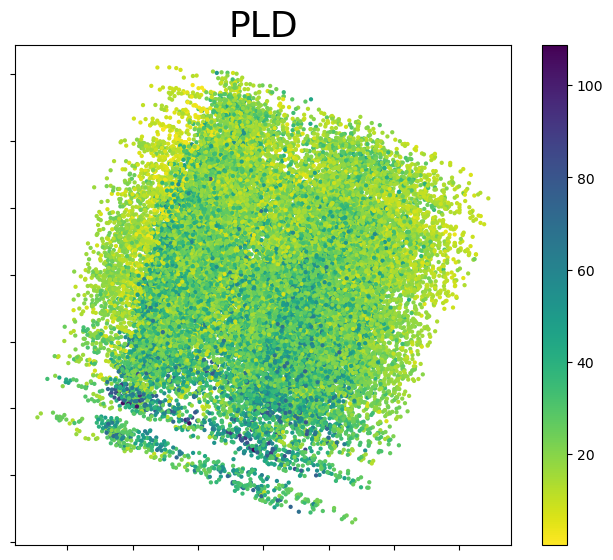

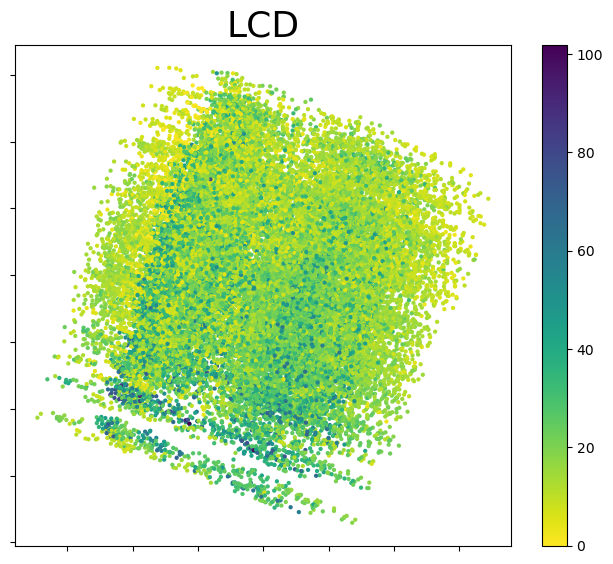

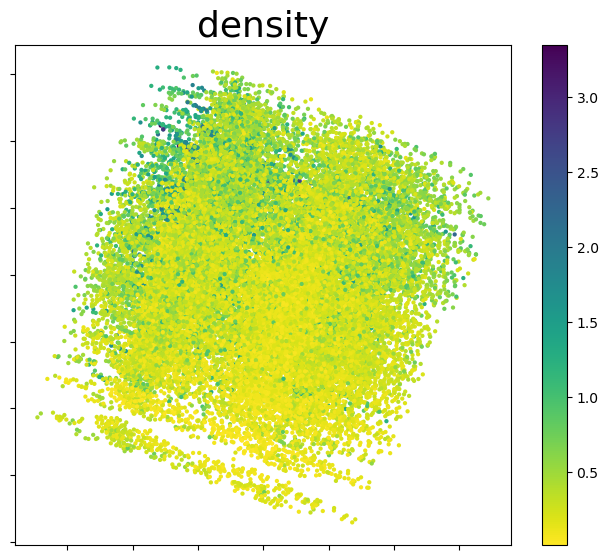

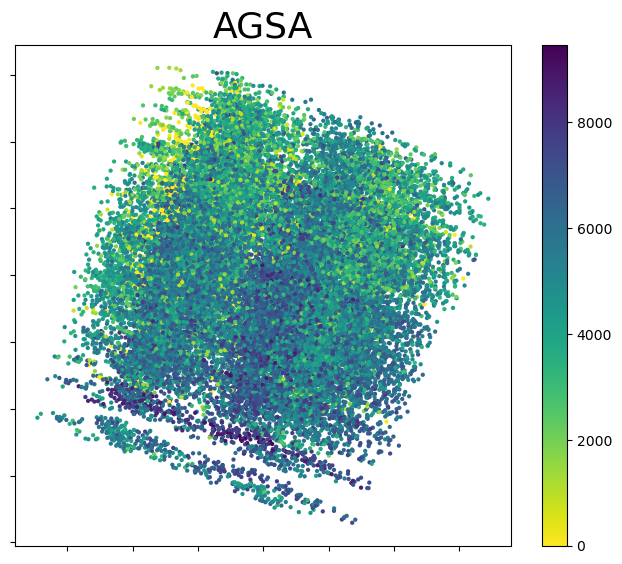

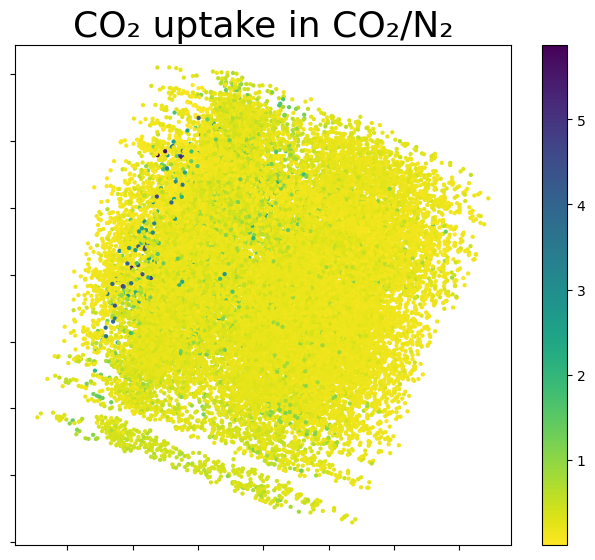

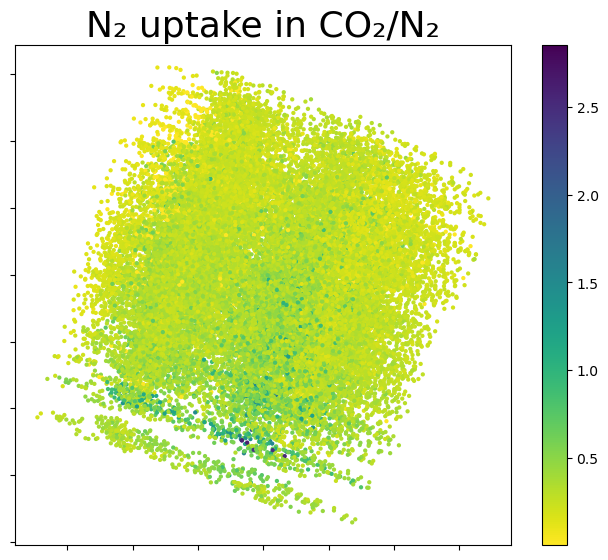

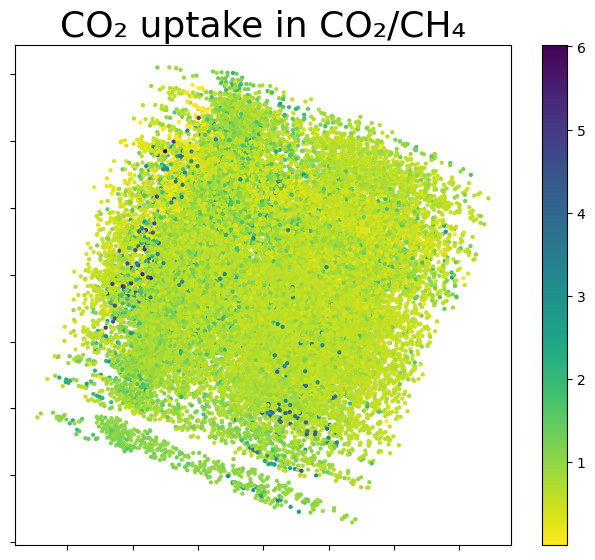

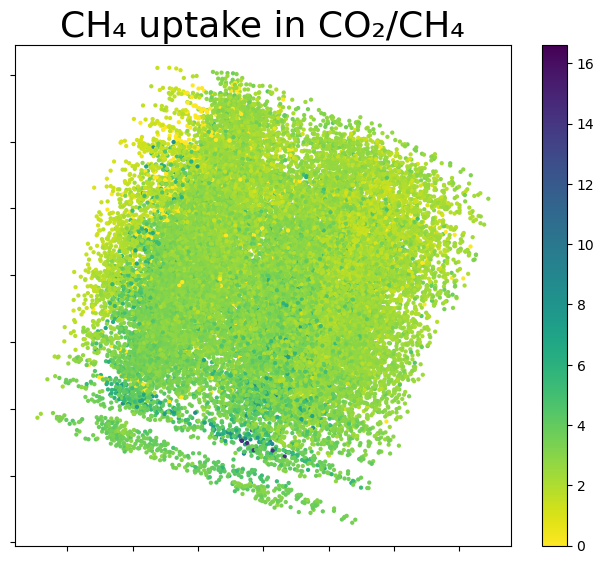

In [10]:
# U, S, V = torch.pca_lowrank(z,  q=2)
# data_pca = torch.matmul(z.cpu(), V)
z_centered = z - z.mean(dim=0)
U, S, V = torch.svd(z_centered)
V_q = V[:, :2]
data_pca = torch.mm(z_centered, V_q)
for index, y_label in enumerate(img_title):
    utils.pca_image(data_pca, y, index, y_label)

R2 of the Validation Set

In [11]:
y_true = OrderedDict()
y_pred = OrderedDict()
for i in range(len(config['col_y'])):
    y_true[i] = []
    y_pred[i] = []
for batch in tqdm(test_dataset):
    root_vecs, tree_vecs, mol_batch = utils.get_vecs(model, batch, device)
    outputs = model_y.z_to_y(root_vecs, tree_vecs)
    y_true_scaler = model_y.scaler.inverse_transform(mol_batch['y'].cpu().numpy())
    for i in range(len(config['col_y'])):
        y_true[i].extend(y_true_scaler[:, i].reshape(-1))
        y_pred[i].extend(outputs[:, i].reshape(-1))
r2_results = utils.regression_statistics(y_true, y_pred, config['col_y'])

  0%|          | 0/1000 [00:00<?, ?it/s]

lcd : R2 =  0.9255340183521433 , MAE =  2.1927084825830176 , RMSE =  3.6586267669623895
pld : R2 =  0.9194142224401364 , MAE =  1.9730736566182199 , RMSE =  3.4677818569579104
density : R2 =  0.9237848162709537 , MAE =  0.04015600674270978 , RMSE =  0.0778349898092804
agsa : R2 =  0.9258702756396011 , MAE =  307.7914144443089 , RMSE =  482.8822069807676
co2n2_co2_mol_kg : R2 =  0.8119149982297506 , MAE =  0.04316284284148402 , RMSE =  0.11100352856995795
co2n2_n2_mol_kg : R2 =  0.9336240829464032 , MAE =  0.02297976550246795 , RMSE =  0.0404637781102559
co2ch4_co2_mol_kg : R2 =  0.872400272383532 , MAE =  0.07225984974296484 , RMSE =  0.15689719961171383
co2ch4_ch4_mol_kg : R2 =  0.8833998372784186 , MAE =  0.1846360523856334 , RMSE =  0.3157667475462152


Find Candidates

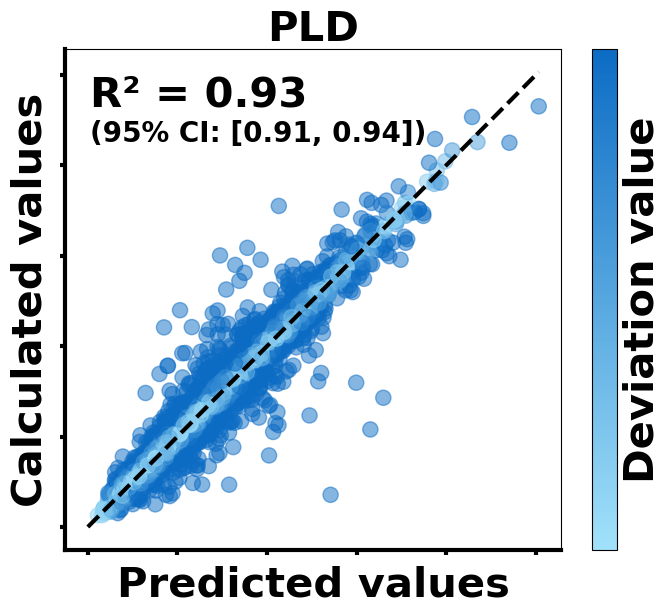

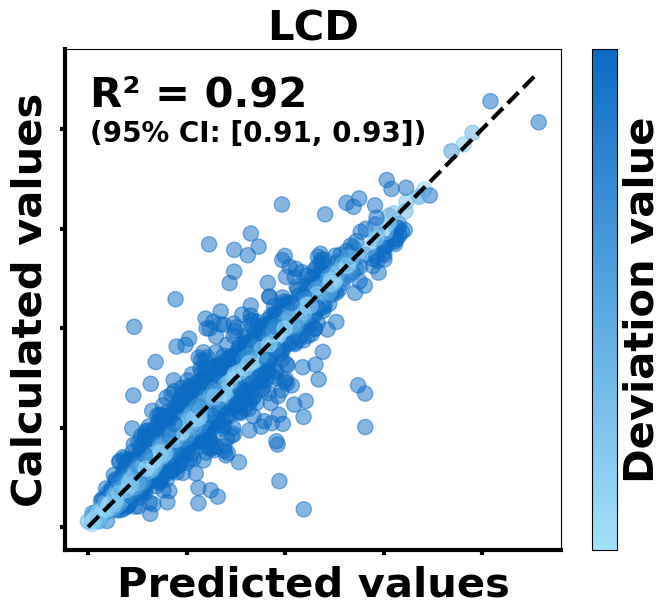

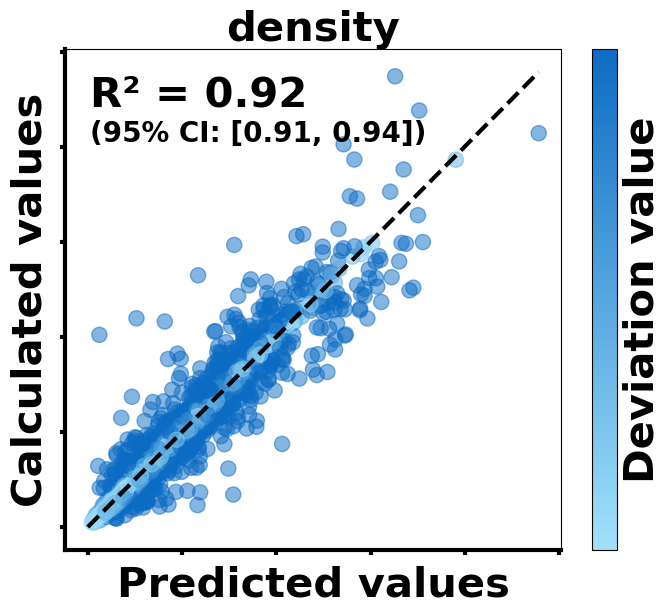

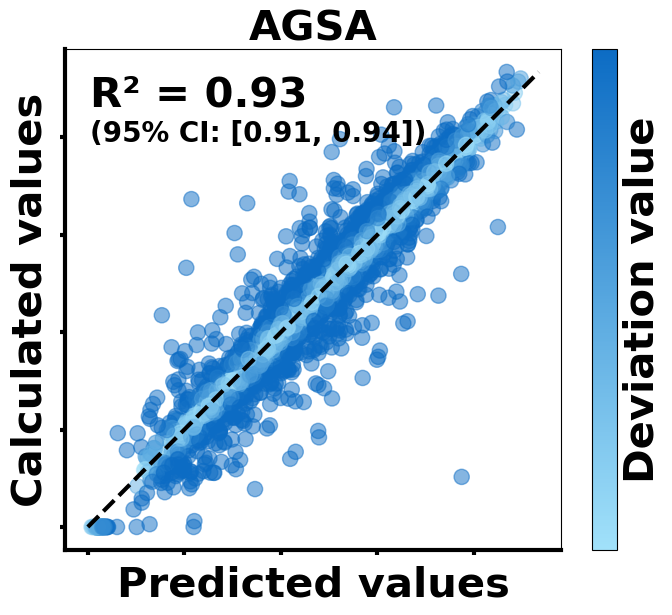

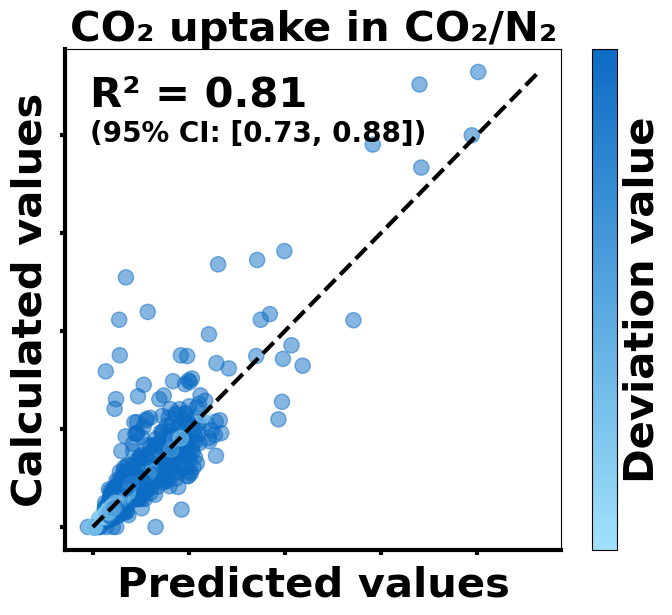

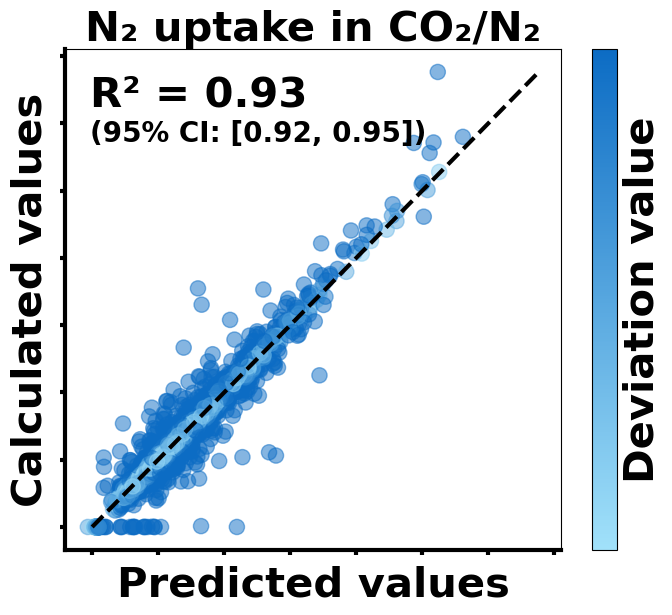

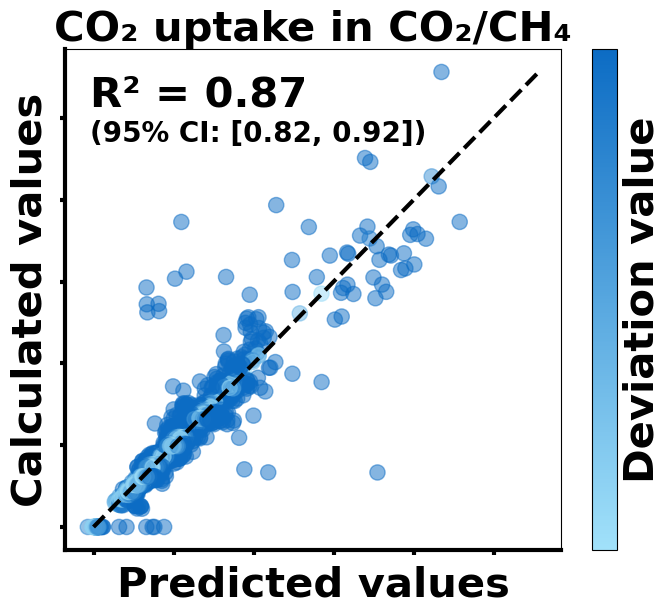

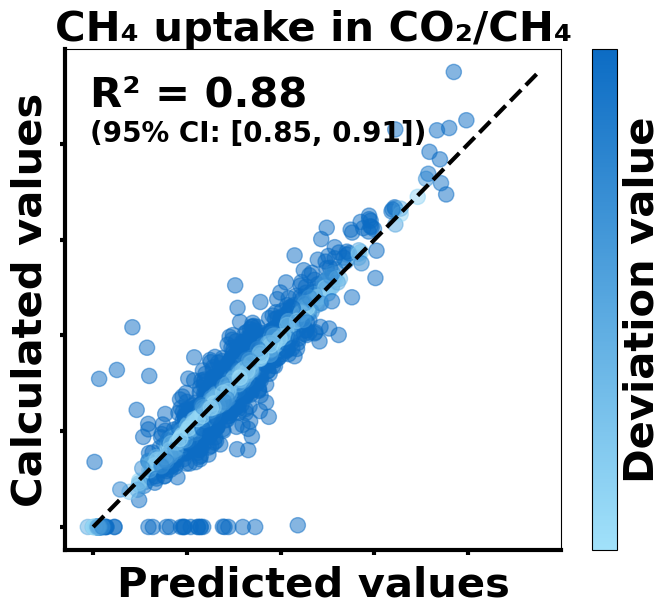

In [19]:
img_title = ['PLD', 'LCD', 'density', 'AGSA', 'CO₂ uptake in CO₂/N₂',
            'N₂ uptake in CO₂/N₂', 'CO₂ uptake in CO₂/CH₄', 'CH₄ uptake in CO₂/CH₄']
for index, r2_title_value in enumerate(img_title):
    r2 = r2_results['R2'][index]
    y_true_values = y_true[index]
    y_pred_values = y_pred[index]
    plt = utils.plot_scatter_with_deviation_and_ci_new(y_true_values, y_pred_values, r2, r2_title_value, index)
    plt.show()

In [20]:
start_mof = [('None', 'sym_6_mc_3', 'pcu', '[Lr]c1ccc(cc1)[Lr]')]

if not os.path.exists(config['x_max']) or not config['x_min']:
    model = inference_model.model
    train_dataset = DataFolder(config['tensors_train_prop'], config['train_batch_size'])
    z = []
    x_max = []
    x_min = []
    with torch.no_grad():
        for batch in tqdm(train_dataset):
            root_vecs, _, _ = utils.get_vecs(model, batch, device)
            z.extend(root_vecs.cpu().numpy())
    z = np.stack(z)
    for index in range(z.shape[1]):
        x_max.append(np.max(z[:, index]))
        x_min.append(np.min(z[:, index]))
    np.save(config['x_max'], x_max)
    np.save(config['x_min'], x_min)
else:
    x_max = np.load(config['x_max'])
    x_min = np.load(config['x_min'])

opt_config_dict = dict(configs.opt_config())
print("optimizer config: ")
print(json.dumps(opt_config_dict, indent=4))

optimizer config: 
{
    "opt_num_part": 10,
    "opt_num_swarms": 1,
    "opt_iterations_num": 50,
    "opt_num_track": 20,
    "opt_fitness_name": "co2n2_co2_mol_kg",
    "opt_col": [
        "fitness",
        "branch_smiles",
        "metal_node",
        "organic_core",
        "topology",
        "lcd",
        "pld",
        "density",
        "agsa",
        "co2n2_co2_mol_kg",
        "co2n2_n2_mol_kg",
        "co2ch4_co2_mol_kg",
        "co2ch4_ch4_mol_kg"
    ],
    "x_min": "results/z_max_min/x_min.npy",
    "x_max": "results/z_max_min/x_max.npy",
    "v_min": -0.4,
    "v_max": 0.4
}


In [21]:
opt = BasePSOptimizer.from_query(
        init_building_list=start_mof,
        num_part=config['opt_num_part'],
        num_swarms=config['opt_num_swarms'],
        inference_model=inference_model,
        fitness_name=config['opt_fitness_name'],
        opt_col=config['opt_col'],
        x_min=x_min,
        x_max=x_max,
        v_min=config['v_min'],
        v_max=config['v_max'],
)
opt.run(config['opt_iterations_num'], num_track=config['opt_num_track'])
display(opt.step_fitness_history)

step  max_fitness  min_fitness  mean_fitness
0     0     0.472516     0.000000      0.425265
0     1     0.571041     0.000000      0.417221
0     2     0.668041     0.472516      0.524605
0     3     0.668041     0.472516      0.524605
0     4     0.674421     0.472516      0.579043
0     5     0.752335     0.496026      0.599523
0     6     0.752335     0.496026      0.599523
0     7     1.254683     0.496026      0.658353
0     8     1.254683     0.496026      0.658353
0     9     1.254683     0.496026      0.658353
0    10     1.254683     0.496026      0.658353
0    11     1.254683     0.496026      0.658353
0    12     1.254683     0.496026      0.658353
0    13     1.254683     0.496026      0.658353
0    14     1.254683     0.496026      0.696719
0    15     1.254683     0.496026      0.696719
0    16     1.254683     0.496026      0.696719
0    17     1.254683     0.496026      0.696719
0    18     1.254683     0.571041      0.727803
0    19     1.254683     0.571041      0.727803
0    20     1.379480     0.625802      0.789666
0    21     1.507494     0.625802      0.903629
0    22     1.524965     0.633548      0.966333
0    23     1.524965     0.650563      0.988009
0    24     1.524965     0.668041      0.997623
0    25     1.524965     0.668041      0.997623
0    26     1.719103     0.752335      1.106016
0    27     1.719103     0.752335      1.106016
0    28     1.719103     0.761365      1.150103
0    29     1.719103     0.761365      1.150103
0    30     1.719103     0.776934      1.181327
0    31     1.719103     0.801617      1.201171
0    32     1.719103     0.801617      1.201171
0    33     1.719103     0.801617      1.201171
0    34     1.719103     0.885350      1.240550
0    35     1.719103     0.885350      1.240550
0    36     1.719103     0.885350      1.240550
0    37     1.719103     0.885350      1.240550
0    38     1.719103     0.980709      1.274254
0    39     1.719103     0.980709      1.274254
0    40     1.719103     0.980709      1.274254
0    41     1.719103     0.998002      1.292939
0    42     1.719103     0.998002      1.292939
0    43     1.719103     0.998002      1.292939
0    44     1.719103     0.998002      1.292939
0    45     1.719103     0.998002      1.292939
0    46     1.719103     0.998002      1.292939
0    47     1.719103     1.067080      1.309557
0    48     1.719103     1.067080      1.309557
0    49     1.719103     1.067080      1.309557

In [22]:
display(opt.best_step_mof_history)

fitness    organic_core    metal_node topology  \
0   0.472516            None    sym_6_mc_3      pcu   
1   0.472516            None    sym_6_mc_3      pcu   
2   0.571041      sym_3_on_1    sym_6_mc_3      pyr   
3   0.668041            None    sym_6_mc_3      pcu   
4   0.266171            None    sym_6_mc_3      pcu   
5   0.674421      sym_3_on_1    sym_6_mc_3      pyr   
6   0.752335      sym_3_on_1    sym_8_mc_8      the   
7   0.329123   sym_3_vae_762  sym_24_mc_13      rht   
8   1.254683      sym_3_on_1    sym_8_mc_8      the   
9   0.376993      sym_3_on_1    sym_4_mc_1      ctn   
10  0.300910      sym_3_on_1    sym_4_mc_1      bor   
11  0.346756     sym_5_on_12    sym_3_mc_0      tbo   
12  0.488400   sym_3_vae_561    sym_9_mc_5      spn   
13  0.450786   sym_4_vae_107    sym_4_mc_1     diab   
14  0.295580      sym_3_on_2    sym_4_mc_1      bor   
15  0.998002     sym_5_on_13    sym_5_mc_2     lvtb   
16  0.271163  sym_3_vae_1168    sym_4_mc_1      bor   
17  0.349594  sym_3_vae_1001    sym_4_mc_1      bor   
18  0.000000   sym_5_vae_218  sym_13_mc_12      ith   
19  0.885350  sym_3_vae_2082    sym_6_mc_3      pyr   
20  0.357994   sym_3_vae_337  sym_24_mc_13      rht   
21  1.379480  sym_5_vae_1526    sym_4_mc_1      pts   
22  1.507494  sym_5_vae_1038    sym_8_mc_8      csq   
23  1.524965  sym_5_vae_1526    sym_3_mc_0      pto   
24  1.067080   sym_5_vae_304    sym_8_mc_8      csq   
25  0.801617   sym_5_vae_218    sym_8_mc_7      csq   
26  0.373473   sym_3_vae_456    sym_8_mc_9      the   
27  1.719103  sym_5_vae_1038    sym_8_mc_8      csq   
28  0.664929  sym_5_vae_1526    sym_8_mc_8      scu   
29  1.634072   sym_5_vae_196    sym_8_mc_8      csq   
30  0.361163   sym_3_vae_165    sym_4_mc_1      bor   
31  1.385841   sym_5_vae_434    sym_4_mc_1      pts   
32  0.998792   sym_5_vae_298    sym_8_mc_9      scu   
33  0.594555   sym_5_vae_218    sym_8_mc_7      csq   
34  0.287336      sym_3_on_1  sym_24_mc_13      rht   
35  1.328368   sym_5_vae_218    sym_5_mc_2     nbob   
36  0.167288  sym_3_vae_1001    sym_4_mc_1      ctn   
37  0.352904   sym_3_vae_251    sym_4_mc_1      ctn   
38  0.229549   sym_4_vae_107    sym_4_mc_1     sodb   
39  1.217211   sym_5_vae_298    sym_5_mc_2     lvtb   
40  0.247169  sym_3_vae_1001    sym_4_mc_1      bor   
41  0.223959      sym_3_on_1    sym_4_mc_1      ctn   
42  1.354400  sym_3_vae_1001    sym_4_mc_1      ctn   
43  0.831041   sym_5_vae_304    sym_8_mc_8      csq   
44  0.159809   sym_5_vae_317    sym_3_mc_0      pto   
45  0.181743  sym_3_vae_1001    sym_4_mc_1      ctn   
46  0.643834   sym_5_vae_298    sym_8_mc_7      csq   
47  0.805242   sym_5_vae_304    sym_3_mc_0      pto   
48  1.179628   sym_5_vae_304    sym_5_mc_2     nbob   
49  0.246528   sym_5_vae_304    sym_5_mc_2     nbob   
50  0.161635  sym_5_vae_1526    sym_4_mc_1      pts   

                                        branch_smiles        lcd        pld  \
0                                  [Lr]c1ccc(cc1)[Lr]   9.109508   6.049568   
1                                  [Lr]c1ccc([Lr])cc1   9.109509   6.049571   
2                                [Lr]C1=[SH]C([Lr])N1   9.684155   5.874075   
3                                  [Lr]c1ccc([Lr])cc1   9.546287   5.609491   
4                                  [Lr]c1ccc([Lr])cc1   9.570144   6.042227   
5                                  [Lr]C1=C([Lr])SNC1   5.670954   3.364038   
6                                  [Lr]C1=NC([Lr])NN1   8.963153   6.160469   
7   CCc1ccc([Lr])cc1-c1cc(CC)c(C(CC)c2ccc([Lr])cc2...  37.486649  25.547268   
8                                  [Lr]C1=NC([Lr])NN1  18.836317  12.627890   
9                                  [Lr]C1=NC([Lr])NN1  28.351418  23.209476   
10                                  [Lr]CNCNCNCNC[Lr]  14.209028  10.519993   
11                                         [Lr]NO[Lr]  21.123882  12.563876   
12  CCCc1cc(-c2ccc(-c3ccc([Lr])cc3)c(C)c2)cc(CC)c1...  44.423050  31.490778   
13                               CCC1=